In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
diffusion="5.0percent"
# diffusion="0.1percent"
# file_id = "1"
# file_id = "2954"
file_id = "2638"


hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_smear_{file_id}.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")

# hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_smear_{file_id}.h5", "MC/hits")
# hits      = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")

# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")
# hits_true["z"]= hits_true["z"]+3000

display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())

,event_id,x,y,z,energy
0,395850,-854.217468,2419.580811,4439.013672,0.000025
1,395850,-864.129700,2415.127686,4442.036133,0.000025
2,395850,-869.613586,2428.859619,4442.308594,0.000124
3,395850,-876.299744,2428.154541,4442.591797,0.000074
4,395850,-859.912659,2430.831543,4442.909668,0.000099
...,...,...,...,...,...
226030,395909,-1652.713013,2573.648438,5089.349609,0.000025
226031,395909,-1628.279175,2603.222656,5095.881348,0.000025
226032,395909,-1653.745361,2592.288818,5097.604492,0.000025
226033,395909,-1640.466675,2592.664062,5099.881348,0.000025


[395850 395851 395852 395853 395854 395855 395856 395857 395858 395859
 395860 395861 395862 395863 395864 395865 395866 395867 395868 395869
 395870 395871 395872 395873 395874 395875 395876 395877 395878 395879
 395880 395881 395882 395883 395884 395885 395886 395887 395888 395889
 395890 395891 395892 395893 395894 395895 395896 395897 395898 395899
 395900 395901 395902 395903 395904 395905 395906 395907 395908 395909]


In [15]:
eid=320000
eid=event_list[24]

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]
display(data_true)

,event_id,x,y,z,energy
25439,395874,2136.002930,1635.687866,4078.843262,0.001414
25440,395874,2139.287354,1637.384766,4079.920898,0.000372
25441,395874,2136.981934,1630.251953,4081.086670,0.002009
25442,395874,2141.659424,1637.894775,4081.575439,0.002902
25443,395874,2137.527344,1627.643555,4082.187744,0.000124
...,...,...,...,...,...
26520,395874,2064.170410,1512.149414,5277.580566,0.000124
26521,395874,2054.557129,1543.207886,5277.612305,0.001860
26522,395874,1997.033936,1486.759521,5277.734375,0.000570
26523,395874,2063.060547,1515.419189,5277.748535,0.001389


In [16]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, voxel_sf, Tortuosity_dist  = InitializeParams(pressure, diffusion)
# voxel_sf=1.1
# energy_threshold=0
print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Voxel scale factor is: ",      voxel_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)

mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))


# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# Create the bins ---- 
xbw  = mean_sigma
xmin = -det_size - mean_sigma/2 
xmax = det_size  + mean_sigma/2

ybw  = mean_sigma
ymin = -det_size - mean_sigma/2 
ymax = det_size  + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

Diffussion smear is:  0.29 mm/sqrt(cm)
Energy threshold is:  0.4 keV
diffision scale factor is:  4
Radius scale factor is:  2
Voxel scale factor is:  2.1
Tortuosity distance scale is: 105.0


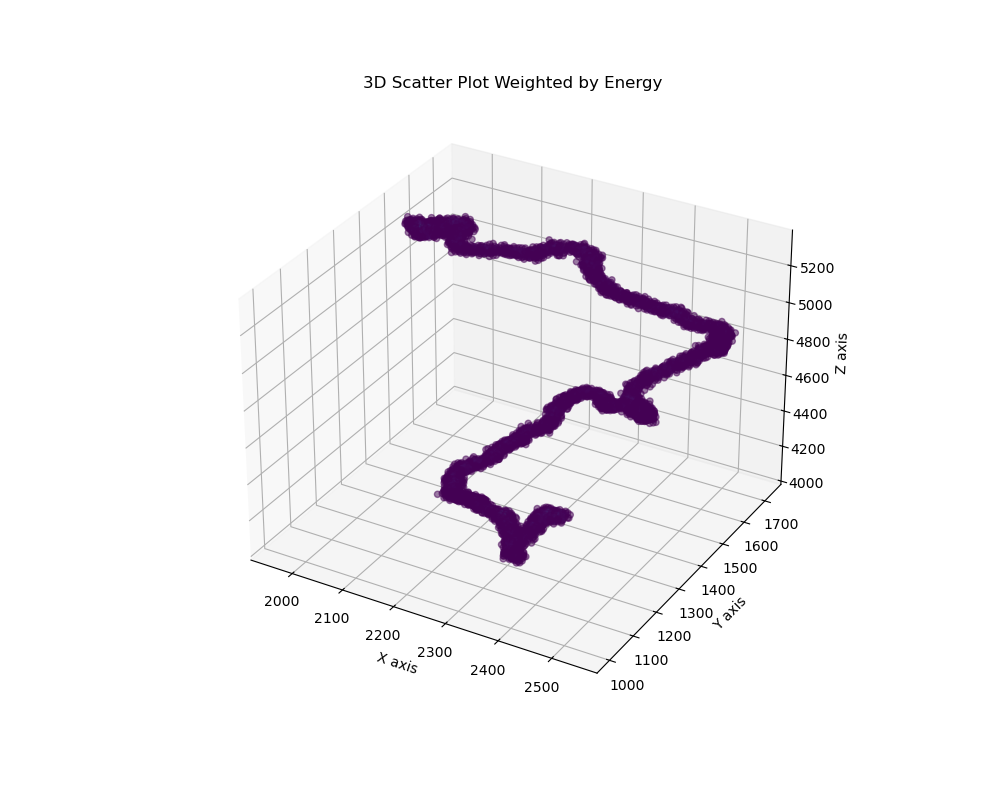

In [17]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [18]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(data)

,event_id,x,y,z,energy
0,395874,1959.346069,1507.917847,5284.193359,0.000025
1,395874,1960.358398,1508.447021,5251.635254,0.000099
2,395874,1961.909302,1494.324097,5274.880371,0.000025
3,395874,1962.138550,1515.544189,5263.708008,0.000025
4,395874,1962.604736,1498.761353,5276.206543,0.000050
...,...,...,...,...,...
4830,395874,2536.789795,1617.847778,4958.380859,0.000050
4831,395874,2537.344971,1627.176270,4943.708984,0.000050
4832,395874,2537.399658,1618.581299,4968.928223,0.000124
4833,395874,2540.209961,1613.038208,4966.236816,0.000025


,event_id,x,y,z,energy
0,395874,1959.346069,1507.917847,5284.193359,0.000025
1,395874,1960.358398,1508.447021,5251.635254,0.000099
2,395874,1961.909302,1494.324097,5274.880371,0.000025
3,395874,1962.138550,1515.544189,5263.708008,0.000025
4,395874,1962.604736,1498.761353,5276.206543,0.000050
...,...,...,...,...,...
4830,395874,2536.789795,1617.847778,4958.380859,0.000050
4831,395874,2537.344971,1627.176270,4943.708984,0.000050
4832,395874,2537.399658,1618.581299,4968.928223,0.000124
4833,395874,2540.209961,1613.038208,4966.236816,0.000025


Mean z: 4670.023  diffusion =  25
Mean Sigma:  25
Total groups created: 1


,x,y,z,energy,group_id
0,1980.409424,1501.129883,5260.664551,0.057879,0
1,1990.340698,1488.888062,5278.881836,0.048927,0
2,1990.744995,1509.529297,5239.162109,0.058290,0
3,1999.498535,1500.130249,5240.328125,0.024625,0
4,2000.945801,1549.116943,5229.292969,0.034985,0
...,...,...,...,...,...
124,2480.201416,1578.833130,5022.050293,0.019753,0
125,2501.056152,1649.546265,4821.148926,0.012943,0
126,2505.703125,1625.978516,4910.737305,0.001644,0
127,2498.852783,1581.883667,5011.177734,0.002730,0


129 2.4537368649616838


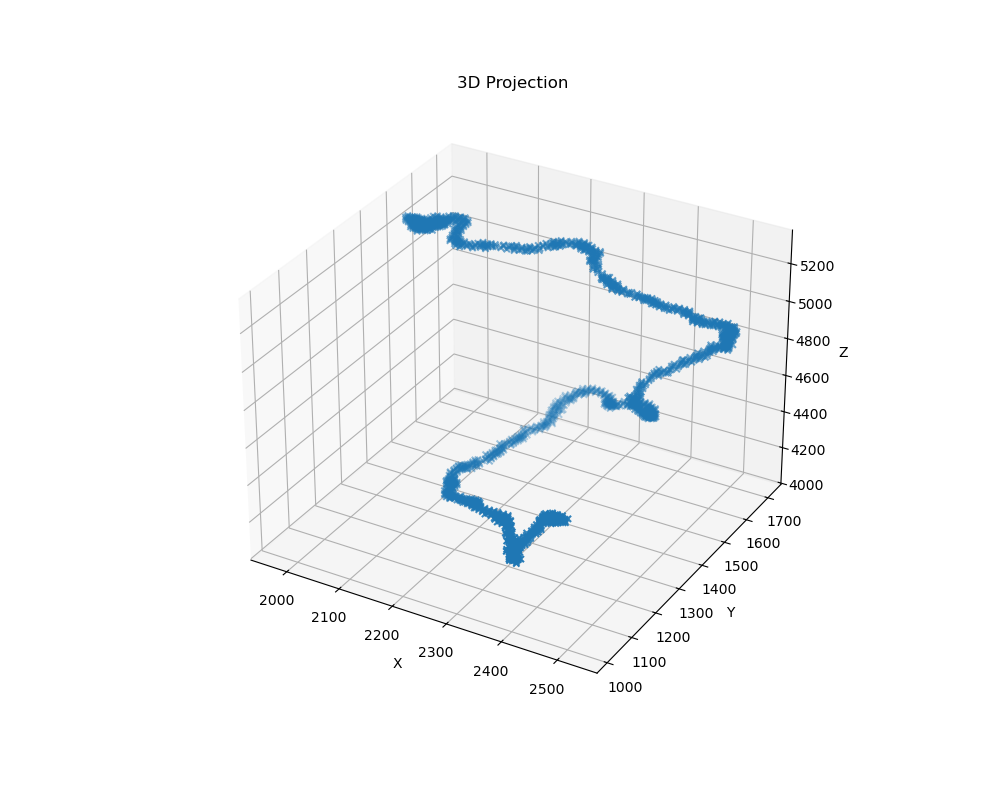

In [19]:

display(data)

print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)
print("Mean Sigma: ", mean_sigma)


# Apply grouping
# voxel size and parameters
voxel_size = mean_sigma  # mm
threshold = voxel_size*voxel_sf

data_copy = data.copy()
df_merged = GroupHits(data_copy, xmin, ymin, zmin, voxel_size, threshold)

# If we have too many groups then bump up the voxel size since the track was broken too much
if (len(df_merged.group_id.unique()) > 10):
    print("Running grouping again")
    df_merged = GroupHits(data_copy, xmin, ymin, zmin, voxel_size, voxel_size*(voxel_sf+1))

df_merged = CutandRedistibuteEnergy(df_merged, energy_threshold)


# Apply clustering
node_centers_df = []

for gid in sorted(df_merged.group_id.unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    temp_df.reset_index(drop=True, inplace=True)
    node_centers_df.append(Cluster(temp_df, mean_sigma))

node_centers_df = pd.concat(node_centers_df, ignore_index=True)

display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gid in sorted(df_merged.group_id.unique()):
    # ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
    # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
    temp_df = df_merged[df_merged.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



In [20]:


databin = node_centers_df.copy()
databin["event_id"] = eid

# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)



# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'], row['group_id'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'group_id' : row['group_id'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['group_id'] = row['group_id']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear, group_id = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum'],           # Sum energy
        'group_id' : int(group_id)
    })

# Create final DataFrame
databin = pd.DataFrame(result)

# then sort it based on the x,y,z
# databin = databin.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,395874.0,1975.0,1500.0,5250.0,1980.409424,1501.129883,5260.664551,0.057879,0
1,395874.0,2000.0,1500.0,5275.0,1999.336365,1488.962708,5279.130127,0.080713,0
2,395874.0,2000.0,1500.0,5250.0,1999.831136,1504.753052,5246.476237,0.113761,0
3,395874.0,2000.0,1550.0,5225.0,2000.945801,1549.116943,5229.292969,0.034985,0
4,395874.0,2000.0,1475.0,5275.0,2000.416260,1471.656128,5270.261719,0.097531,0
...,...,...,...,...,...,...,...,...,...
113,395874.0,2475.0,1650.0,4800.0,2480.116699,1658.658447,4799.323730,0.013941,0
114,395874.0,2475.0,1575.0,5025.0,2480.201416,1578.833130,5022.050293,0.019753,0
115,395874.0,2500.0,1650.0,4825.0,2501.056152,1649.546265,4821.148926,0.012943,0
116,395874.0,2500.0,1625.0,4900.0,2505.703125,1625.978516,4910.737305,0.001644,0


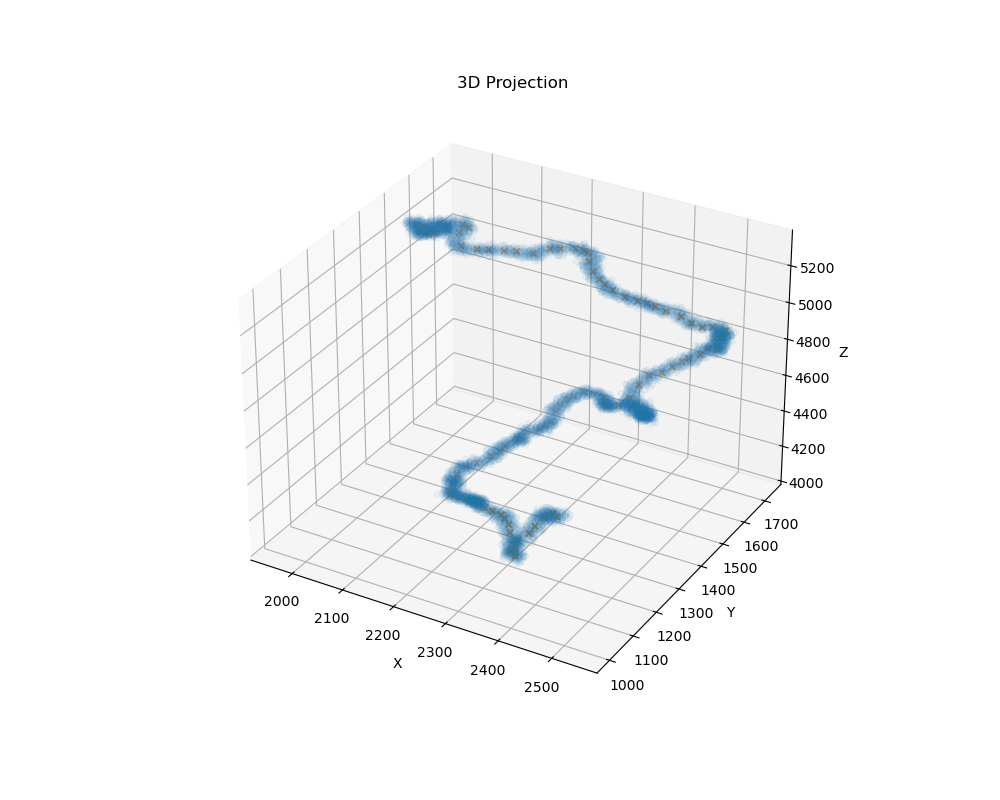

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")


for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

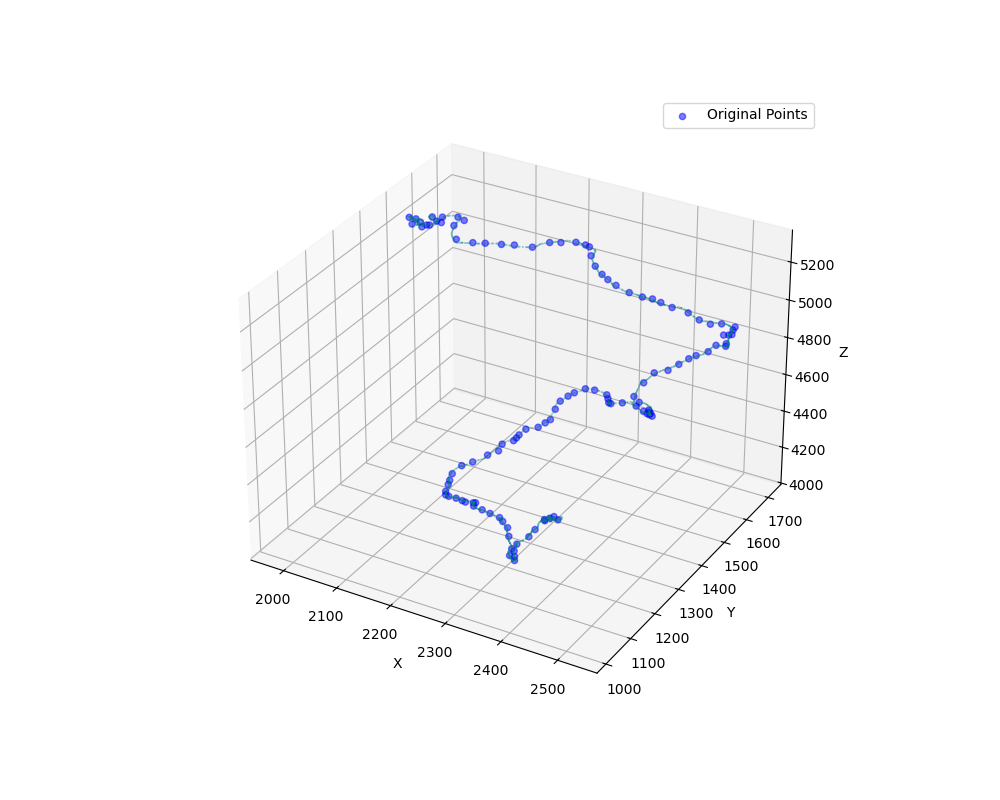

In [22]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Original Points', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,395874.0,1975.0,1500.0,5250.0,1980.409424,1501.129883,5260.664551,0.057879,0
1,395874.0,2000.0,1500.0,5275.0,1999.336365,1488.962708,5279.130127,0.080713,0
2,395874.0,2000.0,1500.0,5250.0,1999.831136,1504.753052,5246.476237,0.113761,0
3,395874.0,2000.0,1550.0,5225.0,2000.945801,1549.116943,5229.292969,0.034985,0
4,395874.0,2000.0,1475.0,5275.0,2000.416260,1471.656128,5270.261719,0.097531,0
...,...,...,...,...,...,...,...,...,...
113,395874.0,2475.0,1650.0,4800.0,2480.116699,1658.658447,4799.323730,0.013941,0
114,395874.0,2475.0,1575.0,5025.0,2480.201416,1578.833130,5022.050293,0.019753,0
115,395874.0,2500.0,1650.0,4825.0,2501.056152,1649.546265,4821.148926,0.012943,0
116,395874.0,2500.0,1625.0,4900.0,2505.703125,1625.978516,4910.737305,0.001644,0


Diffussion smear is:  0.29 mm/sqrt(cm)
Energy threshold is:  0.4 keV
diffision scale factor is:  4
Radius scale factor is:  2
Voxel scale factor is:  2.1
Tortuosity distance scale is: 105.0
Median distance to the closest row: 25.28799903425073
Distances to iterate over [ 1  4  8 11 15 18 22 25 29 32 36 39 43 47 50]
Dist Thresh 111.804
Pass Flag: True
The primary track is:  0
     event_id            x            y            z    energy  group_id   id  \
0    395874.0  2018.340210  1548.608887  5212.654297  0.004901         0    6   
1    395874.0  2000.945801  1549.116943  5229.292969  0.034985         0    4   
2    395874.0  2018.894409  1529.316772  5240.364746  0.029556         0    7   
3    395874.0  2009.563110  1520.698486  5221.657715  0.013619         0    5   
4    395874.0  1999.831136  1504.753052  5246.476237  0.113761         0    2   
..        ...          ...          ...          ...       ...       ...  ...   
113  395874.0  2400.545654  1154.181152  4405.743164  0

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,,
6,395874.0,2018.340210,1548.608887,5212.654297,0.004901,0,6,1,0,0.000000,0.000000,2.470133,1.506685
4,395874.0,2000.945801,1549.116943,5229.292969,0.034985,0,4,1,0,24.076316,29.881384,1.826883,0.863299
7,395874.0,2018.894409,1529.316772,5240.364746,0.029556,0,7,1,0,53.003528,101.432296,1.619035,0.705441
5,395874.0,2009.563110,1520.698486,5221.657715,0.013619,0,5,1,0,75.615494,108.168814,1.779207,0.864191
2,395874.0,1999.831136,1504.753052,5246.476237,0.113761,0,2,1,0,106.678772,109.636788,2.167789,1.203343
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,395874.0,2400.545654,1154.181152,4405.743164,0.057086,0,90,1,0,3311.137306,66.802723,1.557899,0.649528
96,395874.0,2409.972900,1149.326782,4428.708984,0.084118,0,96,1,0,3336.432894,3.052141,1.775922,0.842698
92,395874.0,2401.314941,1132.514771,4419.826660,0.068680,0,92,1,0,3357.325469,112.706037,1.741647,0.604467


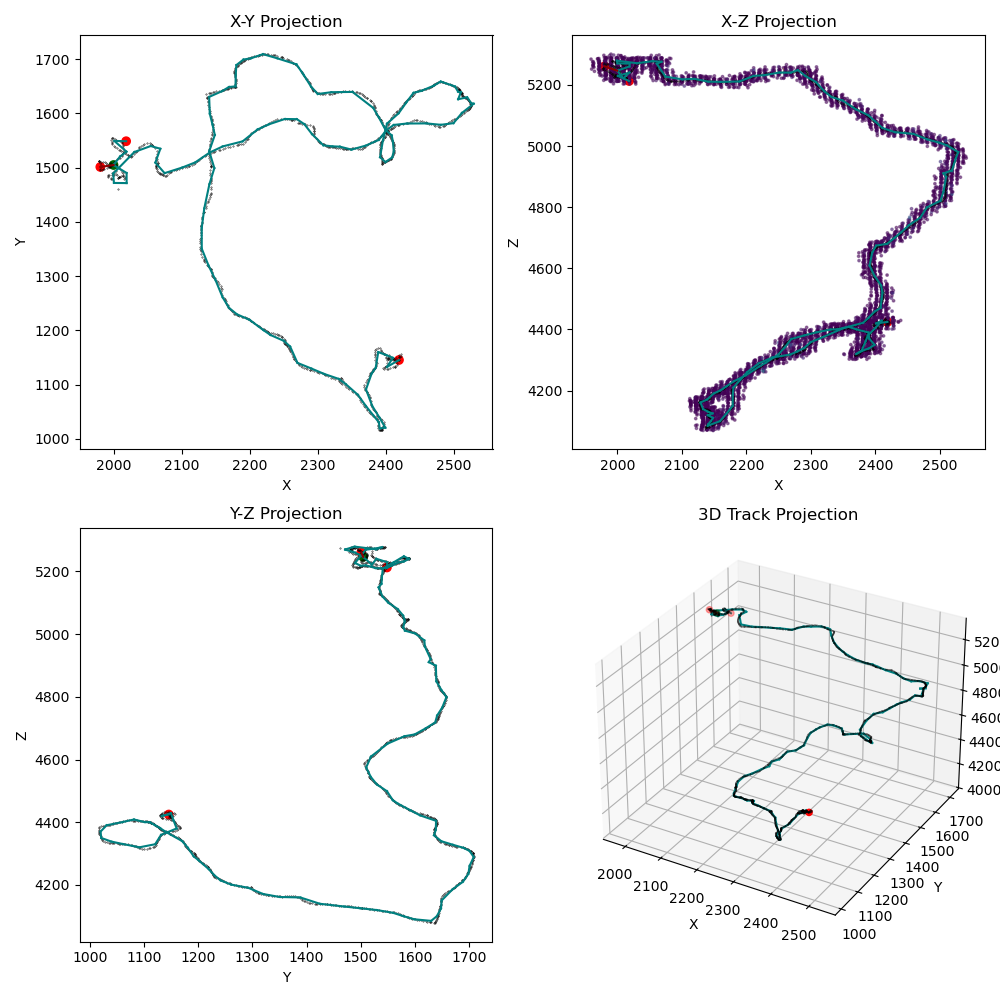

In [23]:
# Apply the tracking reconstruction

display(databin)


# df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)
df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy", "group_id"]], 0, pressure, diffusion, 0)

df.index = df.id

display(df)

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
# axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.5,s=3)
axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
# axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
# ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)

plt.tight_layout()
plt.show()

In [24]:
temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure, pressure) # scale these params inversely with the pressure
temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
display(temp_meta)

Adding Delta0 energy to blob1 as dist was 58.393867048825136


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,395874.0,0,1,6,100,3379.560,2.395858,0.641772,0.580283,0.641772,0.590967,2.556118,1.573363,1.486601,0.771554,Primary
0,395874.0,1,0,2,0,24.324,0.057879,0.057879,0.057879,0.000000,0.057879,0.000000,0.000000,0.000000,0.000000,Delta0


Text(0, 0.5, 'RMS')

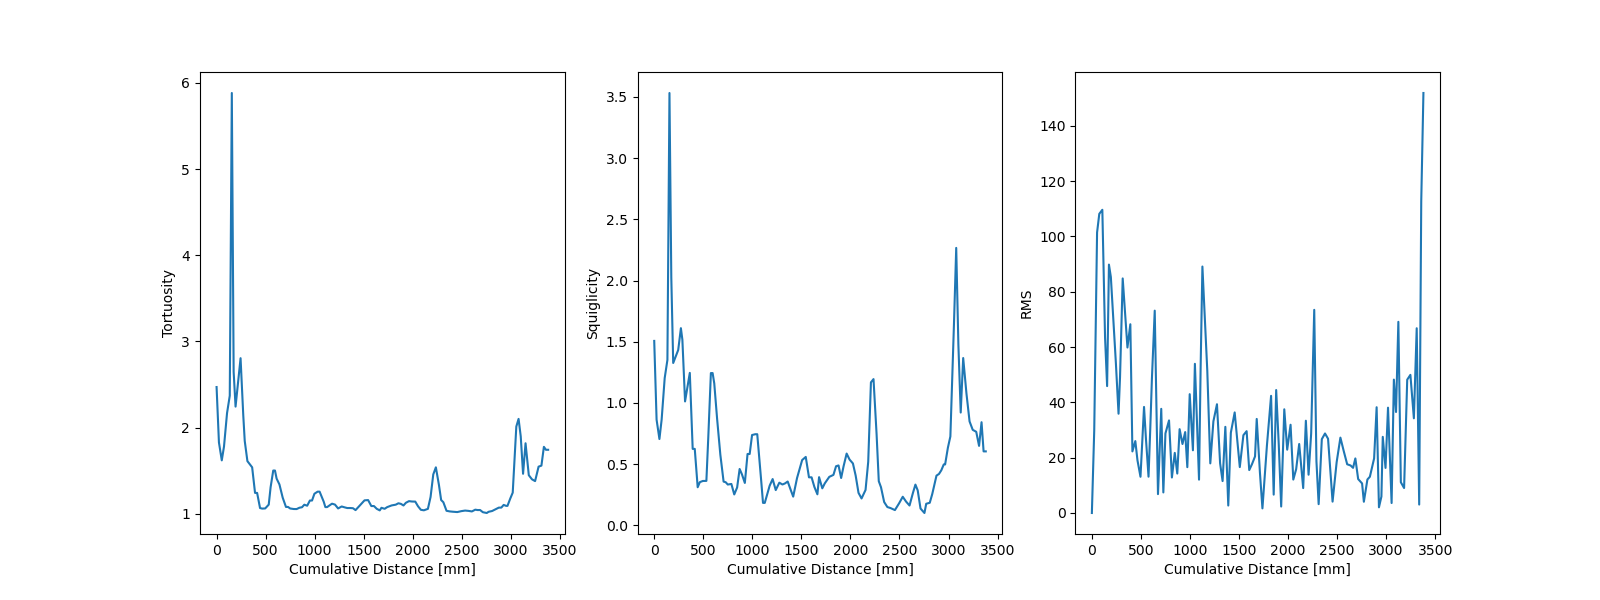

In [25]:

fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Tortuosity"])
axs[0].set_xlabel("Cumulative Distance [mm]")
axs[0].set_ylabel("Tortuosity")

axs[1].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Squiglicity"])
axs[1].set_xlabel("Cumulative Distance [mm]")
axs[1].set_ylabel("Squiglicity")


axs[2].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["angle"])
axs[2].set_xlabel("Cumulative Distance [mm]")
axs[2].set_ylabel("RMS")